In [ ]:
# # Load the Drive helper and mount
# from google.colab import drive

# # This will prompt for authorization.
# drive.mount('/content/drive')

# # After executing above, Drive files will be accessible in path "/content/drive/MyDrive"

Mounted at /content/drive


# Import libraries

In [ ]:
import pandas as pd
pd.set_option("display.max_columns", 200)

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, TunedThresholdClassifierCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifier, RidgeClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, make_scorer, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.frozen import FrozenEstimator

from sklearn import set_config
set_config(transform_output="pandas")

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

from xgboost import XGBClassifier, XGBRFClassifier

from lightgbm import LGBMClassifier

from category_encoders import HashingEncoder

import joblib

import sys
src_path = '../src'
# src_path = '/content/drive/MyDrive/kaggle/src' # Google Colab 
sys.path.insert(0, src_path)
from eval_classification import eval_classification
del sys.path[0]

# Import preprocessor and prepared data

In [ ]:
lib_path = '../lib/' # local machine
# lib_path = '/content/drive/MyDrive/kaggle/lib' # Google Colab

saved = joblib.load(lib_path + "preprocessor.joblib")
preprocessor = saved["preprocessor"]

# Import data and merge prepared data

In [ ]:
input_path = "../../kaggle/input/home-credit-default-risk/" # local machine
# input_path = "/kaggle/input/home-credit-default-risk/" # Kaggle
# input_path = "/content/drive/MyDrive/kaggle/input/home-credit-default-risk/" # Google Colab

application_train = pd.read_csv(input_path + "application_train.csv")
bureau_loans_and_balances = pd.read_csv(lib_path + "bureau_loans_and_balances.csv")
balances_and_payments = pd.read_csv(lib_path + "balances_and_payments.csv")

application_train = pd.merge(application_train, bureau_loans_and_balances, how="left", on="SK_ID_CURR")
application_train = pd.merge(application_train, balances_and_payments, how="left", on="SK_ID_CURR")

application_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY_BUREAU,MONTHS_BALANCE,STATUS,NUM_INSTALMENT_VERSION_INSTALL,NUM_INSTALMENT_NUMBER_INSTALL,DAYS_INSTALMENT_INSTALL,DAYS_ENTRY_PAYMENT_INSTALL,AMT_INSTALMENT_INSTALL,AMT_PAYMENT_INSTALL,MONTHS_BALANCE_POS,CNT_INSTALMENT_POS,CNT_INSTALMENT_FUTURE_POS,SK_DPD_POS,SK_DPD_DEF_POS,MONTHS_BALANCE_CC,AMT_BALANCE_CC,AMT_CREDIT_LIMIT_ACTUAL_CC,AMT_DRAWINGS_ATM_CURRENT_CC,AMT_DRAWINGS_CURRENT_CC,AMT_DRAWINGS_OTHER_CURRENT_CC,AMT_DRAWINGS_POS_CURRENT_CC,AMT_INST_MIN_REGULARITY_CC,AMT_PAYMENT_CURRENT_CC,AMT_PAYMENT_TOTAL_CURRENT_CC,AMT_RECEIVABLE_PRINCIPAL_CC,AMT_RECIVABLE_CC,AMT_TOTAL_RECEIVABLE_CC,CNT_DRAWINGS_ATM_CURRENT_CC,CNT_DRAWINGS_CURRENT_CC,CNT_DRAWINGS_OTHER_CURRENT_CC,CNT_DRAWINGS_POS_CURRENT_CC,CNT_INSTALMENT_MATURE_CUM_CC,SK_DPD_CC,SK_DPD_DEF_CC
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,-109646.0,0.0,-40752.0,-72756.0,73472.580,0.0,1.225277e+07,3932496.00,127954.26,0.0,-69516.0

In [9]:
# split data
X = application_train.drop(columns=["TARGET", "SK_ID_CURR"])
y = application_train["TARGET"].copy()

In [10]:
# Training split:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
preprocessor.fit(X_train, y_train)

X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

# Model Testing

## Logistic Regression

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       0.96      0.69      0.80    226132             0       0.96      0.69      0.80     56554 
           1       0.16      0.68      0.26     19876             1       0.16      0.67      0.26      4949 
                                                                                                             
    accuracy                           0.69    246008      accuracy                           0.69     61503 
   macro avg       0.56      0.68      0.53    246008     macro avg       0.56      0.68      0.53     61503 
weighted avg       0.90      0.69      0.76    246008  weighted avg       0.90      0.69      0.76     61503 


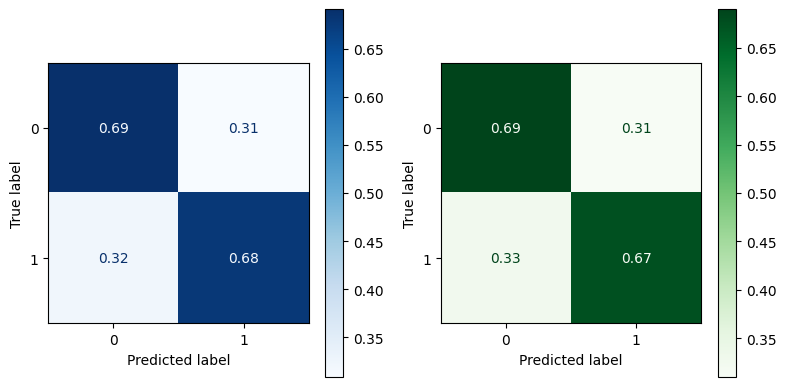

In [12]:
logreg = LogisticRegression(max_iter=1000, class_weight="balanced").fit(X_train, y_train)

logreg_results = eval_classification(logreg, X_train, y_train, X_test, y_test,
                              model_name="Logistic Regression")

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       0.96      0.69      0.80    226132             0       0.96      0.69      0.80     56554 
           1       0.16      0.68      0.26     19876             1       0.16      0.67      0.26      4949 
                                                                                                             
    accuracy                           0.69    246008      accuracy                           0.69     61503 
   macro avg       0.56      0.69      0.53    246008     macro avg       0.56      0.68      0.53     61503 
weighted avg       0.90      0.69      0.76    246008  weighted avg       0.90      0.69      0.76     61503 


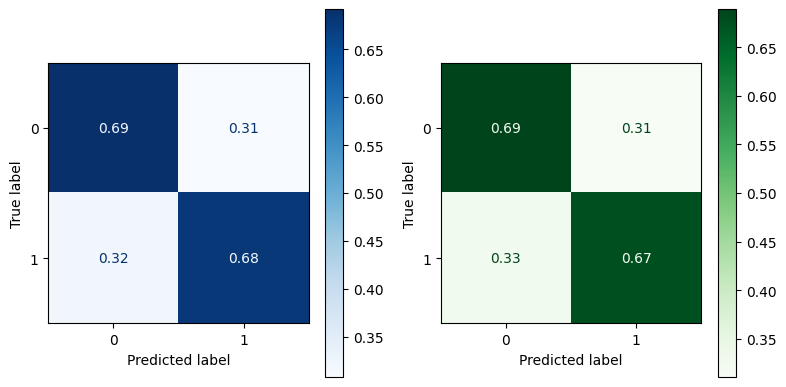

In [13]:
logreg_cv = LogisticRegressionCV(max_iter=1000, class_weight="balanced", Cs=100, cv=8, scoring="roc_auc").fit(X_train, y_train)

logreg_cv_results = eval_classification(logreg_cv, X_train, y_train, X_test, y_test,
                              model_name="Logistic Regression CV", results_frame=logreg_results)

## Decision Trees

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       1.00      1.00      1.00    226132             0       0.93      0.92      0.92     56554 
           1       1.00      1.00      1.00     19876             1       0.16      0.17      0.16      4949 
                                                                                                             
    accuracy                           1.00    246008      accuracy                           0.86     61503 
   macro avg       1.00      1.00      1.00    246008     macro avg       0.54      0.55      0.54     61503 
weighted avg       1.00      1.00      1.00    246008  weighted avg       0.86      0.86      0.86     61503 


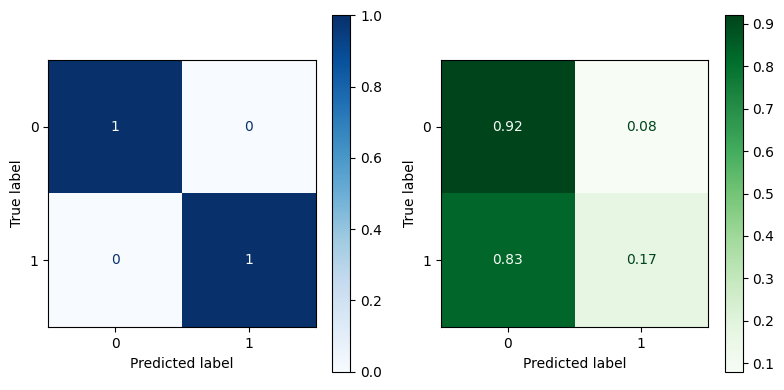

In [14]:
dt = DecisionTreeClassifier(random_state=42, class_weight="balanced").fit(X_train, y_train)

dt_results = eval_classification(dt, X_train, y_train, X_test, y_test,
                                  model_name="Decision Tree", results_frame=logreg_cv_results)

In [16]:
dt.get_depth()

95

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       0.96      0.67      0.79    226132             0       0.95      0.67      0.79     56554 
           1       0.15      0.65      0.24     19876             1       0.14      0.63      0.23      4949 
                                                                                                             
    accuracy                           0.67    246008      accuracy                           0.67     61503 
   macro avg       0.55      0.66      0.51    246008     macro avg       0.55      0.65      0.51     61503 
weighted avg       0.89      0.67      0.74    246008  weighted avg       0.89      0.67      0.74     61503 


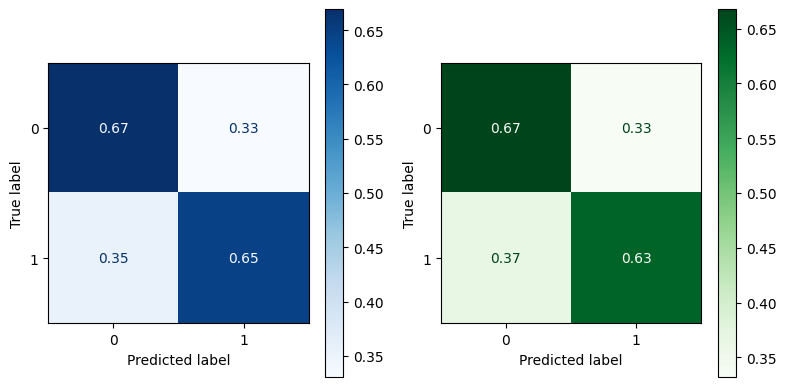

In [17]:
dt_params = {'max_depth': [5, 10, 20, 40, 80, 95]}
dt_gs = GridSearchCV(dt, dt_params, scoring="roc_auc")
dt_gs.fit(X_train, y_train)
dt_cv = dt_gs.best_estimator_.fit(X_train, y_train)

dt_cv_results = eval_classification(dt_cv, X_train, y_train, X_test, y_test,
                                  model_name="Decision Tree CV", results_frame=dt_results)

## K Nearest Neighbors

In [ ]:
# knn = KNeighborsClassifier().fit(X_train, y_train)

# knn_results = eval_classification(knn, X_train, y_train, X_test, y_test,
#                                   model_name="K Nearest Neighbors", results_frame=dt_cv_results)

In [ ]:
# knn.get_params()

In [ ]:
# knn_params = {'n_neighbors': range(3,8),
#               'leaf_size': [10, 20, 30, 40, 50]}
# knn_gs = GridSearchCV(knn, knn_params, scoring="roc_auc")
# knn_gs.fit(X_train, y_train)
# knn_cv = knn_gs.best_estimator_.fit(X_train, y_train)

# knn_cv_results = eval_classification(knn_cv, X_train, y_train, X_test, y_test,
#                                   model_name="K Nearest Neighbors CV", results_frame=knn_results)

## Random Forests

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       1.00      1.00      1.00    226132             0       0.92      1.00      0.96     56554 
           1       1.00      1.00      1.00     19876             1       0.50      0.00      0.00      4949 
                                                                                                             
    accuracy                           1.00    246008      accuracy                           0.92     61503 
   macro avg       1.00      1.00      1.00    246008     macro avg       0.71      0.50      0.48     61503 
weighted avg       1.00      1.00      1.00    246008  weighted avg       0.89      0.92      0.88     61503 


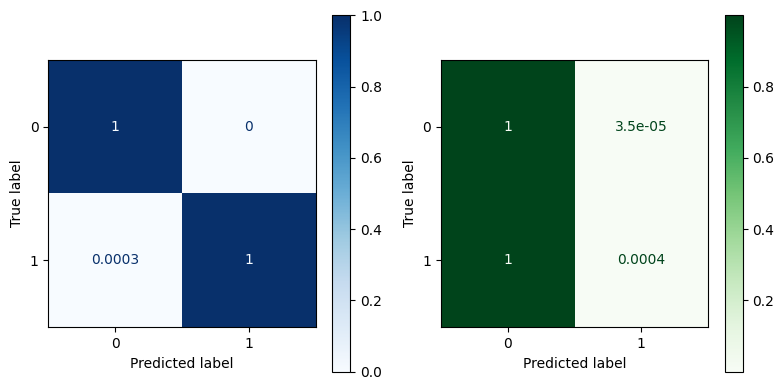

In [20]:
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

rf_results = eval_classification(rf, X_train, y_train, X_test, y_test,
                                  model_name="Random Forest", results_frame=dt_cv_results)

In [21]:
# rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [22]:
# rf_params = {"class_weight" : ["balanced", "balanced_subsample"],
#              "n_estimators" : [10, 50, 100, 150]}
# rf_gs = GridSearchCV(rf, rf_params, scoring="roc_auc")
# rf_gs.fit(X_train, y_train)
# rf_cv = rf_gs.best_estimator_.fit(X_train, y_train)

# rf_cv_results = eval_classification(rf_cv, X_train, y_train, X_test, y_test,
#                                   model_name="Random Forest CV", results_frame=rf_results)

KeyboardInterrupt: 

## Ridge regression classifier

In [ ]:
# AttributeError: 'RidgeClassifier' object has no attribute 'predict_proba'


# ridge = RidgeClassifier(random_state=42, class_weight="balanced")
# ridge.fit(X_train, y_train)

# ridge_results = eval_classification(ridge, X_train, y_train, X_test, y_test,
#                               model_name="Ridge Classifier")
# # , results_frame=rf_cv_results

In [ ]:
# AttributeError: 'RidgeClassifierCV' object has no attribute 'predict_proba'


# ridge_cv = RidgeClassifierCV(class_weight="balanced", scoring="roc_auc")
# ridge_cv.fit(X_train, y_train)

# ridge_cv_results = eval_classification(ridge_cv, X_train, y_train, X_test, y_test,
#                               model_name="Ridge Classifier CV", roc_auc_average="macro")
# # , results_frame=rf_cv_results

## Histogram-based Gradient Boosting Classification Tree

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       0.97      0.72      0.83    226132             0       0.96      0.72      0.82     56554 
           1       0.19      0.74      0.30     19876             1       0.17      0.68      0.28      4949 
                                                                                                             
    accuracy                           0.73    246008      accuracy                           0.71     61503 
   macro avg       0.58      0.73      0.57    246008     macro avg       0.57      0.70      0.55     61503 
weighted avg       0.91      0.73      0.79    246008  weighted avg       0.90      0.71      0.78     61503 


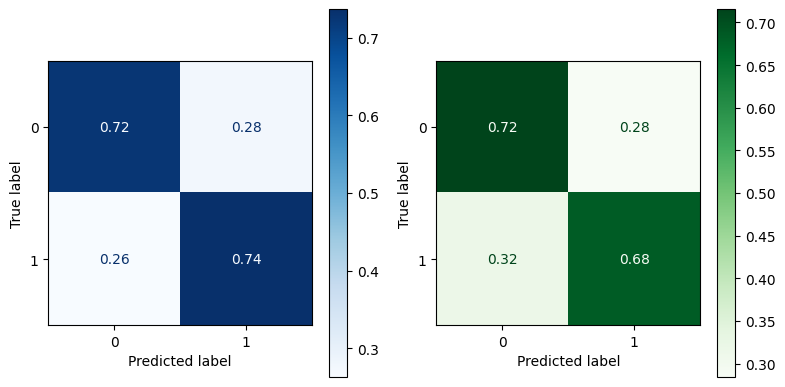

In [23]:
hgb = HistGradientBoostingClassifier(scoring="roc_auc", random_state=42, class_weight="balanced").fit(X_train, y_train)

hgb_results = eval_classification(hgb, X_train, y_train, X_test, y_test,
                                  model_name="Histogram-based Gradient Boosting Classification Tree", results_frame=rf_results)

## XGBoost Classifiers

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       0.93      1.00      0.96    226132             0       0.92      0.99      0.96     56554 
           1       0.83      0.11      0.20     19876             1       0.46      0.05      0.09      4949 
                                                                                                             
    accuracy                           0.93    246008      accuracy                           0.92     61503 
   macro avg       0.88      0.56      0.58    246008     macro avg       0.69      0.52      0.53     61503 
weighted avg       0.92      0.93      0.90    246008  weighted avg       0.89      0.92      0.89     61503 


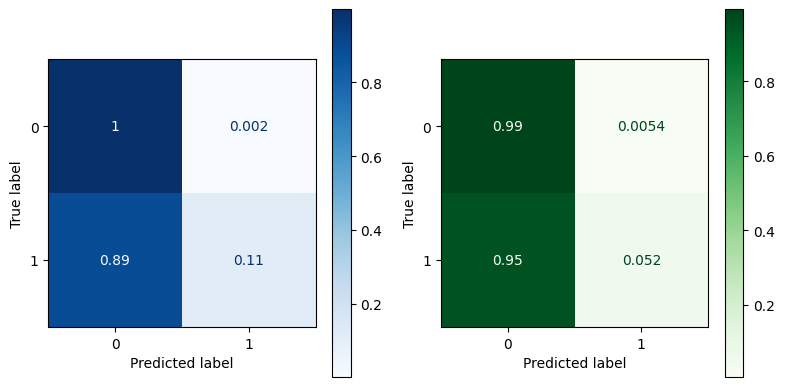

In [24]:
xgb = XGBClassifier().fit(X_train, y_train)

xgb_results = eval_classification(xgb, X_train, y_train, X_test, y_test,
                                  model_name="XGBoost", results_frame=hgb_results)

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       0.92      1.00      0.96    226132             0       0.92      1.00      0.96     56554 
           1       0.59      0.03      0.05     19876             1       0.47      0.02      0.04      4949 
                                                                                                             
    accuracy                           0.92    246008      accuracy                           0.92     61503 
   macro avg       0.76      0.51      0.50    246008     macro avg       0.69      0.51      0.50     61503 
weighted avg       0.89      0.92      0.88    246008  weighted avg       0.88      0.92      0.88     61503 


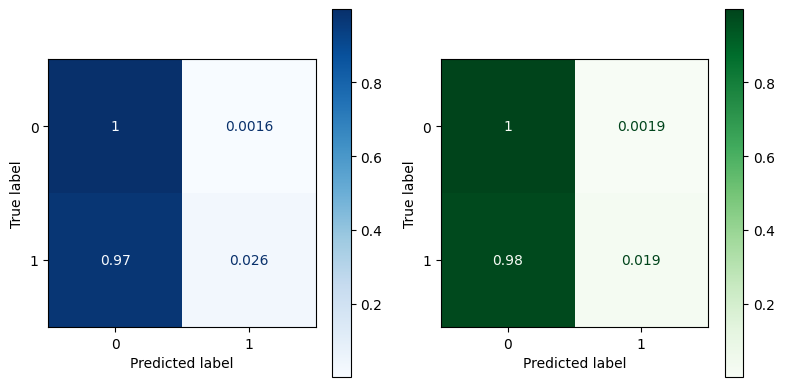

In [25]:
xgbrf = XGBRFClassifier().fit(X_train, y_train)

xgbrf_results = eval_classification(xgbrf, X_train, y_train, X_test, y_test,
                                  model_name="XGBoost Random Forest", results_frame=xgb_results)

## Naive Bayes algorithms

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       0.96      0.04      0.07    226132             0       0.96      0.04      0.07     56554 
           1       0.08      0.98      0.15     19876             1       0.08      0.98      0.15      4949 
                                                                                                             
    accuracy                           0.11    246008      accuracy                           0.11     61503 
   macro avg       0.52      0.51      0.11    246008     macro avg       0.52      0.51      0.11     61503 
weighted avg       0.89      0.11      0.08    246008  weighted avg       0.89      0.11      0.08     61503 


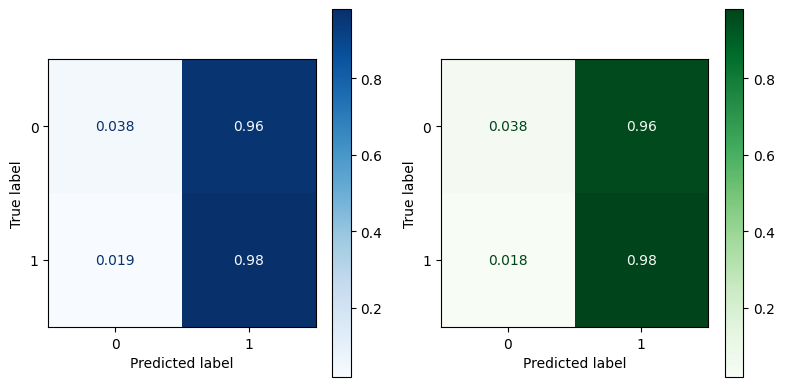

In [26]:
gnb = GaussianNB().fit(X_train, y_train)

gnb_results = eval_classification(gnb, X_train, y_train, X_test, y_test,
                                  model_name="Gaussian", results_frame=xgbrf_results)

                    Train Evaluation                                       Test Evaluation                   
              precision    recall  f1-score   support                precision    recall  f1-score   support 
                                                                                                             
           0       0.93      0.88      0.91    226132             0       0.93      0.88      0.90     56554 
           1       0.17      0.28      0.21     19876             1       0.17      0.28      0.21      4949 
                                                                                                             
    accuracy                           0.83    246008      accuracy                           0.83     61503 
   macro avg       0.55      0.58      0.56    246008     macro avg       0.55      0.58      0.56     61503 
weighted avg       0.87      0.83      0.85    246008  weighted avg       0.87      0.83      0.85     61503 


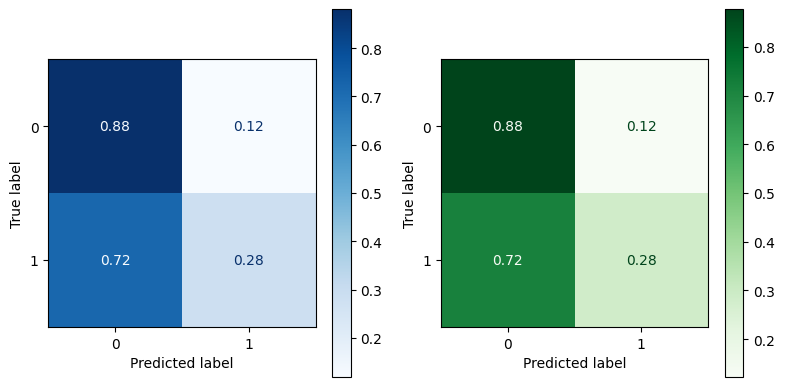

In [27]:
bnb = BernoulliNB().fit(X_train, y_train)

bnb_results = eval_classification(bnb, X_train, y_train, X_test, y_test,
                                  model_name="Bernoulli", results_frame=gnb_results)

# Stacking Classifier

## First we need to pick which models to stack

In [28]:
bnb_results.style.background_gradient()

,train_acc,test_acc,train_prec,test_prec,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
Logistic Regression,0.690437,0.688779,0.161935,0.159990,0.678155,0.674682,0.261441,0.258647,0.750534,0.748568
Logistic Regression CV,0.690656,0.688129,0.162130,0.159684,0.678708,0.674682,0.261736,0.258247,0.750368,0.748386
Decision Tree,1.000000,0.859275,1.000000,0.156725,1.000000,0.170944,1.000000,0.163526,1.000000,0.545227
Decision Tree CV,0.667438,0.665301,0.146531,0.143307,0.645905,0.634674,0.238871,0.233818,0.710574,0.704387
Random Forest,0.999976,0.919532,1.000000,0.500000,0.999698,0.000404,0.999849,0.000808,1.000000,0.723879
Histogram-based Gradient Boosting Classification Tree,0.725233,0.713006,0.190156,0.173672,0.736718,0.682966,0.302288,0.276924,0.808299,0.770277
XGBoost,0.926539,0.918752,0.832841,0.457295,0.113554,0.051930,0.199858,0.093268,0.869526,0.764910
XGBoost Random Forest,0.919864,0.919321,0.592677,0.467337,0.026062,0.018792,0.049928,0.036131,0.731344,0.724039
Gaussian,0.114313,0.114271,0.082289,0.082003,0.981284,0.981612,0.151845,0.151361,0.521921,0.522480
Bernoulli,0.832347,0.829618,0.171403,0.167988,0.280388,0.282683,0.212751,0.210740,0.671753,0.669317


In [33]:
estimators = [('hgb', hgb),
              ('xgb', xgb),
              ('logreg', logreg_cv)]

stacked_clf = StackingClassifier(estimators=estimators).fit(X_train, y_train)


stacked_clf_results = eval_classification(stacked_clf, X_train, y_train, X_test, y_test,
                                  model_name="Stacked Classifier", results_frame=bnb_results)

              # ('svc', make_pipeline(preprocessor, StandardScaler(), LinearSVC(random_state=42))),

# stacked_clf_pipe = make_pipeline(StandardScaler(), stacked_clf

# ('gnb', gnb),


KeyboardInterrupt: 

In [ ]:
stacked_clf_results.style.background_gradient()

# Threshold Tuning

In [ ]:
# tuned_threshold = TunedThresholdClassifierCV(clf_stack, random_state=42).fit(X_train, y_train)

# tuned_threshold_results = eval_classification(tuned_threshold, X_train, y_train, X_test, y_test,
#                                   model_name="Tuned Threshold Classifer", results_frame=stacked_results)

# tuned_threshold_results

# Calibration

In [ ]:
stacked_clf.fit(X_train, y_train)
calibrated_clf = CalibratedClassifierCV(FrozenEstimator(stacked_clf), method="isotonic", cv=10)
calibrated_clf.fit(X_test, y_test)

calibrated_clf_results = eval_classification(calibrated_clf, X_train, y_train, X_test, y_test,
                                  model_name="Calibrated Classifier", results_frame=stacked_clf_results)

# Export and Submission

## Input

In [34]:
test_data_file = "application_test.csv"
application_test = pd.read_csv(input_path + test_data_file)

## Processing

In [35]:
installments_payments = pd.read_csv(input_path + "installments_payments.csv")
POS_CASH_balance = pd.read_csv(input_path + "POS_CASH_balance.csv")
credit_card_balance = pd.read_csv(input_path + "credit_card_balance.csv")

idx = pd.DataFrame(application_test['SK_ID_CURR'])

# INSTALL pipeline
installments_payments.drop(columns="SK_ID_PREV", inplace=True)
installments_payments.columns = [col + "_INSTALL" for col in installments_payments.columns]
merge_INSTALL = pd.merge(idx, installments_payments, how="inner", left_on="SK_ID_CURR", right_on="SK_ID_CURR_INSTALL")
merge_INSTALL.drop(columns="SK_ID_CURR_INSTALL", inplace=True)
merge_INSTALL = merge_INSTALL.sort_values(by="NUM_INSTALMENT_NUMBER_INSTALL", ascending=False).drop_duplicates(subset=["SK_ID_CURR"])

# POS pipeline
POS_CASH_balance.drop(columns="SK_ID_PREV", inplace=True)
POS_CASH_balance.columns = [col + "_POS" for col in POS_CASH_balance.columns]
merge_POS = pd.merge(idx, POS_CASH_balance, how="inner", left_on="SK_ID_CURR", right_on="SK_ID_CURR_POS")
merge_POS.drop(columns="SK_ID_CURR_POS", inplace=True)
merge_POS = merge_POS.sort_values(by="MONTHS_BALANCE_POS", ascending=False).drop_duplicates(subset=["SK_ID_CURR"])

# CC pipeline
credit_card_balance.drop(columns="SK_ID_PREV", inplace=True)
credit_card_balance.columns = [col + "_CC" for col in credit_card_balance.columns]
merge_CC = pd.merge(idx, credit_card_balance, how="inner", left_on="SK_ID_CURR", right_on="SK_ID_CURR_CC")
merge_CC.drop(columns="SK_ID_CURR_CC", inplace=True)
merge_CC = merge_CC.sort_values(by="MONTHS_BALANCE_CC", ascending=False).drop_duplicates(subset=["SK_ID_CURR"])

# Merge down
balances_and_payments = pd.merge(merge_INSTALL, merge_POS, how="outer", left_on="SK_ID_CURR", right_on="SK_ID_CURR")
balances_and_payments = pd.merge(balances_and_payments, merge_CC, how="outer", left_on="SK_ID_CURR", right_on="SK_ID_CURR")

# Drop object columns
# balances_and_payments.select_dtypes(include="object")
balances_and_payments.drop(labels=["NAME_CONTRACT_STATUS_POS", "NAME_CONTRACT_STATUS_CC"], axis=1, inplace=True)

application_test = pd.merge(application_test, bureau_loans_and_balances, how="left", on="SK_ID_CURR")
application_test = pd.merge(application_test, balances_and_payments, how="left", on="SK_ID_CURR")


ids = application_test.pop("SK_ID_CURR")
application_test = preprocessor.transform(application_test)

preds = gnb.predict_proba(application_test)[:,1]

output = pd.DataFrame({"SK_ID_CURR": ids,
                       "TARGET": preds})

## Output

In [36]:
output

,SK_ID_CURR,TARGET
0,100001,1.000000e+00
1,100005,1.000000e+00
2,100013,1.000000e+00
3,100028,1.000000e+00
4,100038,1.000000e+00
...,...,...
48739,456221,1.000000e+00
48740,456222,1.000000e+00
48741,456223,1.000000e+00
48742,456224,4.614253e-24


## Export

In [37]:
sample_submission_file = "sample_submission.csv"
sample_submission_df = pd.read_csv(input_path + sample_submission_file)
sample_submission_df["TARGET"] = preds
sample_submission_df.to_csv("02_bad_gnb.csv", index=False)
sample_submission_df.head()

,SK_ID_CURR,TARGET
0,100001,1.0
1,100005,1.0
2,100013,1.0
3,100028,1.0
4,100038,1.0
